TP Final DSP

In [2]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

mat_struct = sio.loadmat('./ECG_TP4.mat')
qrs_det = mat_struct['qrs_detections']
ecg_one_lead = mat_struct['ecg_lead']

# La señal fue muestreada a 1KHz
fs = 1000
Ts = 1/fs

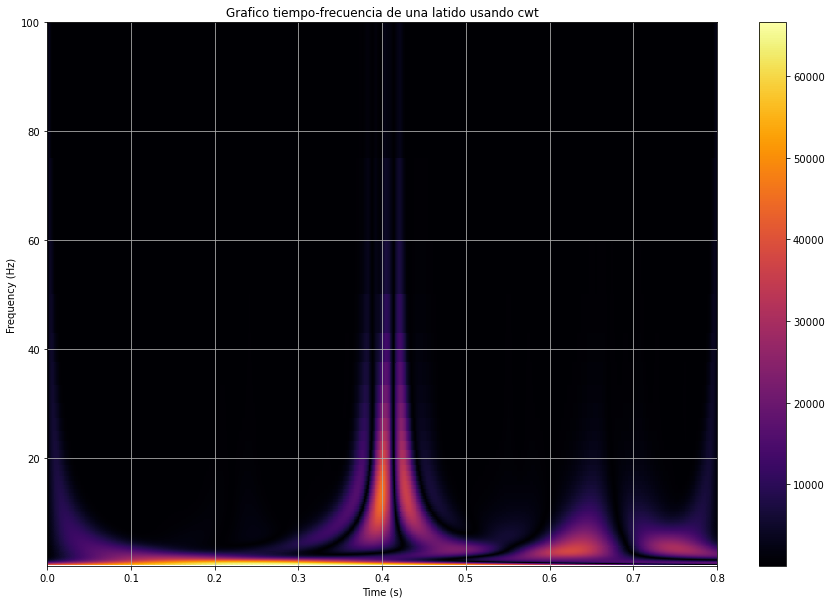

In [3]:
# Tiempo-Frecuencia de un latido
N = 800
N2 = int(N/2)

lat_pos = qrs_det[0]
lat_per = ecg_one_lead[int(lat_pos-N2):int(lat_pos+N2)]

widths = np.arange(3, 1000)
cwtmatr, freqs = pywt.cwt(lat_per.reshape(N),widths,'gaus2',sampling_period=Ts)

t = np.linspace(start=0, stop=N*Ts, num=N)
plt.figure(figsize=(15, 10))
plt.pcolormesh(t, freqs, abs(cwtmatr), cmap = "inferno")
plt.title('Grafico tiempo-frecuencia de una latido usando cwt')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.grid(True)
plt.colorbar()

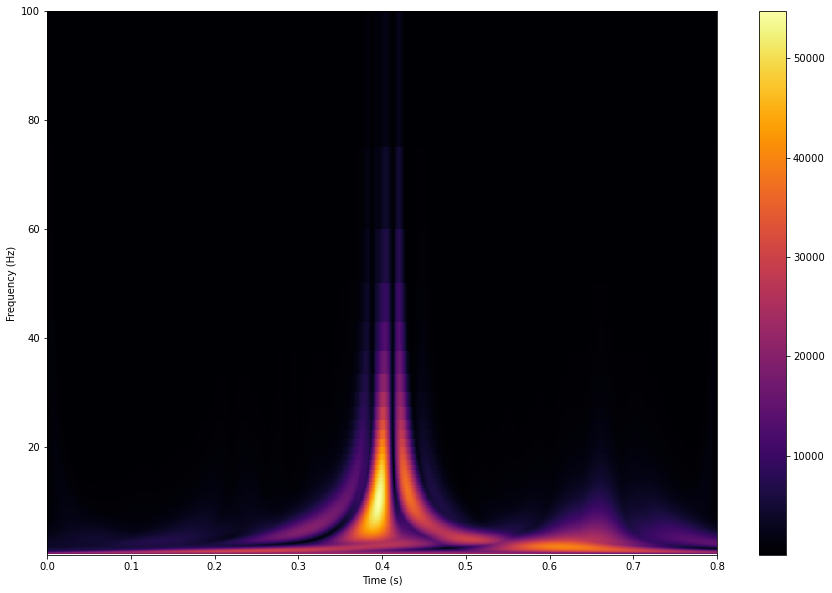

In [4]:
# Grafico de Tiempo-Frecuencia de promedio de cwt de latidos
ecg_part = ecg_one_lead[0:100000]

N = 800
N2 = int(N/2)
widths = np.arange(3, 1000)
i = 0

TempSum = np.zeros([len(widths),N])
for lat in qrs_det:
    per = ecg_part[int(lat-N2):int(lat+N2)]
    auxLen = len(per)
    if auxLen != 0:
        cwtmatr, freqs=pywt.cwt(per.reshape(N),widths,'gaus2',sampling_period=Ts)
        TempSum += abs(cwtmatr)
        i += 1
AvgCwt = TempSum / i
t = np.linspace(start=0, stop=N*Ts, num=N)
plt.figure(figsize=(15, 10))
plt.pcolormesh(t, freqs, abs(AvgCwt), cmap = "inferno")
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.colorbar()

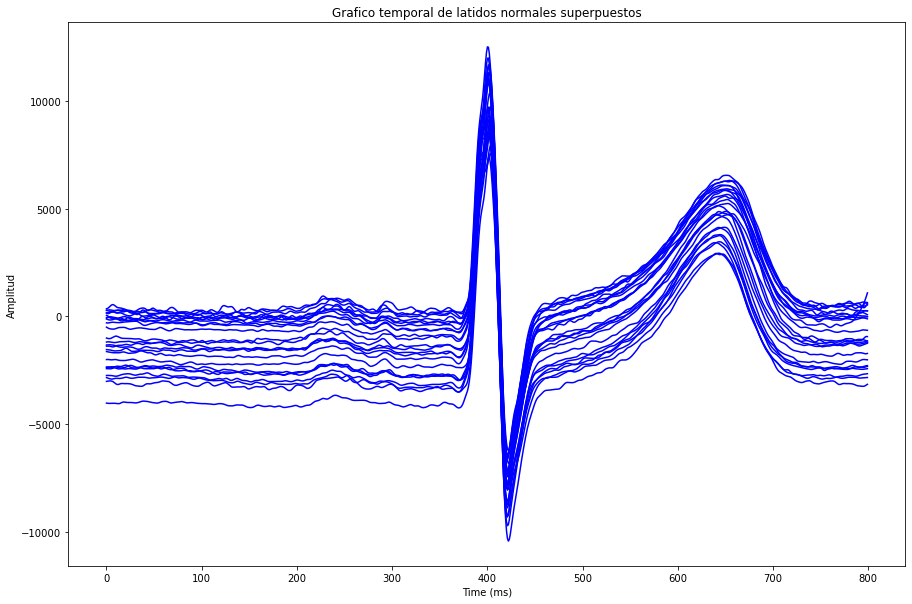

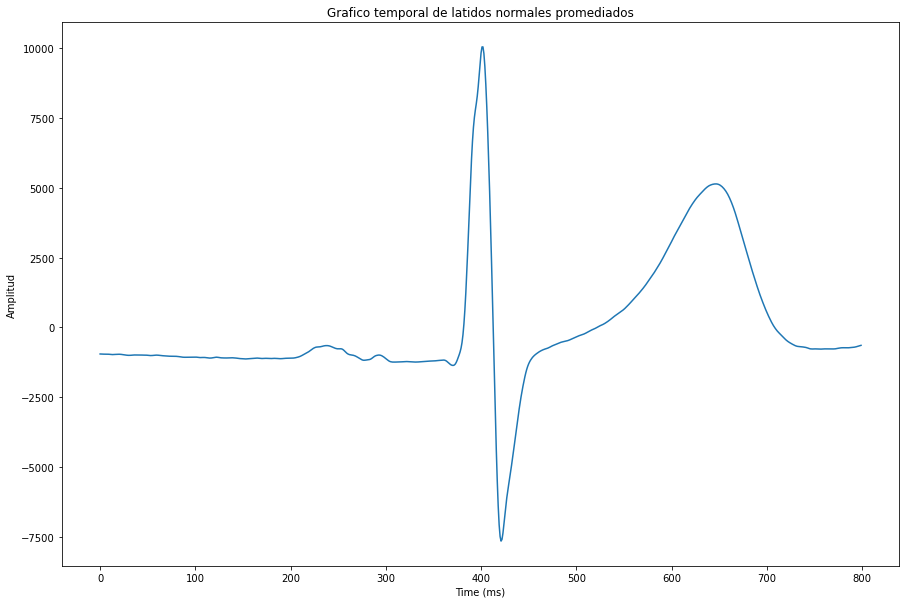

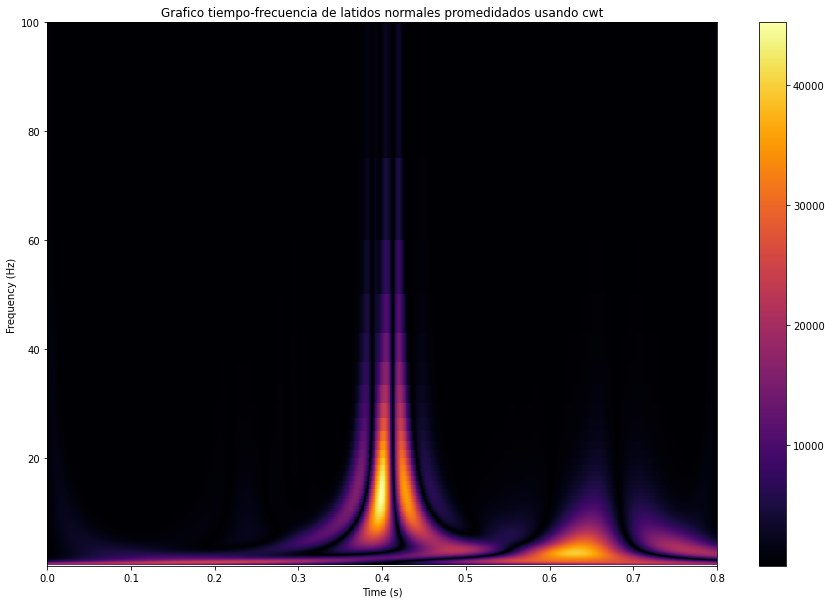

In [5]:
# Grafico de Tiempo-Frecuencia de cwt de promedio de latidos
normal_hb = np.arange(0,10)
b = np.arange(14,29)
normal_hb = np.concatenate((normal_hb,b))

N = 800
N2 = int(N/2)
latidos = np.zeros([N,len(normal_hb)])
i = 0
plt.figure(figsize=(15, 10))
plt.title('Grafico temporal de latidos normales superpuestos')
plt.ylabel('Amplitud')
plt.xlabel('Time (ms)')
for pos in normal_hb:
    lat_pos = int(qrs_det[pos])
    lat = ecg_one_lead[lat_pos-N2:lat_pos+N2]
    latidos[:,i] = lat[:,0]
    i += 1
    plt.plot(lat, color="blue")
    
hb_avg = np.mean(latidos,axis=1)
hb_avg -= np.mean(hb_avg)
plt.figure(figsize=(15, 10))
plt.plot(hb_avg)
plt.title('Grafico temporal de latidos normales promediados')
plt.ylabel('Amplitud')
plt.xlabel('Time (ms)')

widths = np.arange(3, 1000)
cwtmatr, freqs=pywt.cwt(hb_avg.reshape(N),widths,'gaus2',sampling_period=Ts)
t = np.linspace(start=0, stop=N*Ts, num=N)
plt.figure(figsize=(15, 10))
plt.pcolormesh(t, freqs, abs(cwtmatr), cmap = "inferno")
plt.title('Grafico tiempo-frecuencia de latidos normales promedidados usando cwt')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.colorbar()

Text(0.5, 0, 'Tiempo (ms)')

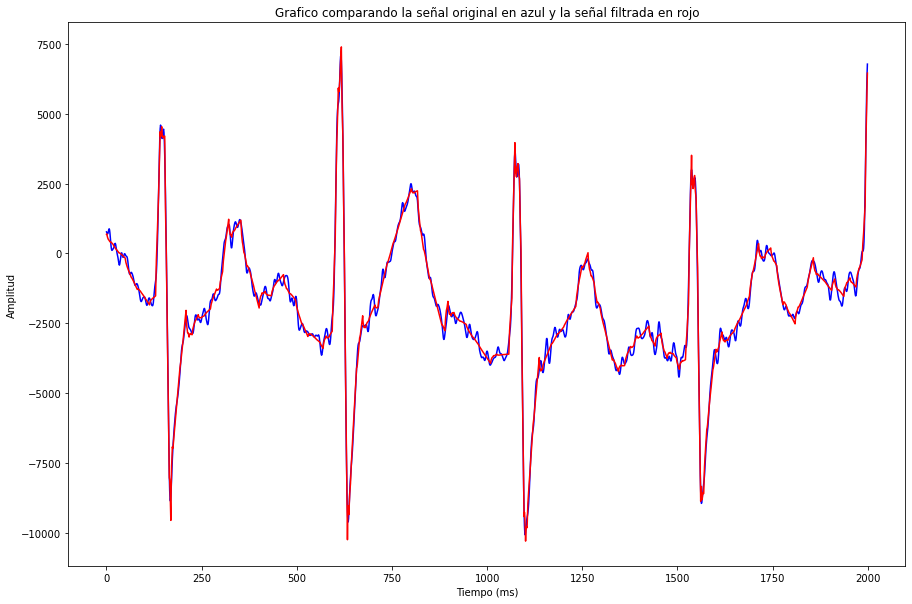

In [6]:
# Filtrado del ruido de alta frecuencia del ecg realizando una descomposicion multiresolucion con la dwt
# Usando la funcion exponencial

N = len(ecg_one_lead)
LastLevel = 10

coeffs = pywt.wavedec(ecg_one_lead.reshape(N), 'db2', level=LastLevel)

alfa = 0.5
desvio = 1.483 * np.median(abs(np.concatenate(coeffs[1:-1], axis=None)))
th = desvio*np.sqrt(2*np.log(N)) * 3
for j in range(1,len(coeffs)):
    threshold = th / np.log(LastLevel-j+2)
    for i in range(len(coeffs[j])):
        if abs(coeffs[j][i]) < threshold:
            coeffs[j][i] = 0
        else:
            coeffs[j][i] = np.sign(coeffs[j][i]) * (abs(coeffs[j][i]) - threshold/np.exp(alfa*(abs(coeffs[j][i])-threshold)/threshold)  )

# coeffs[0][:] = 0

# plt.figure()
# plt.plot(coeffs[LastLevel])

signal = pywt.waverec(coeffs, 'db2')

plt.figure(figsize=(15, 10))
plt.plot(ecg_one_lead[710800:712800],color='blue')
plt.plot(signal[710800:712800],color='red')
plt.title('Grafico comparando la señal original en azul y la señal filtrada en rojo')
plt.ylabel('Amplitud')
plt.xlabel('Tiempo (ms)')

Text(0.5, 0, 'Tiempo (ms)')

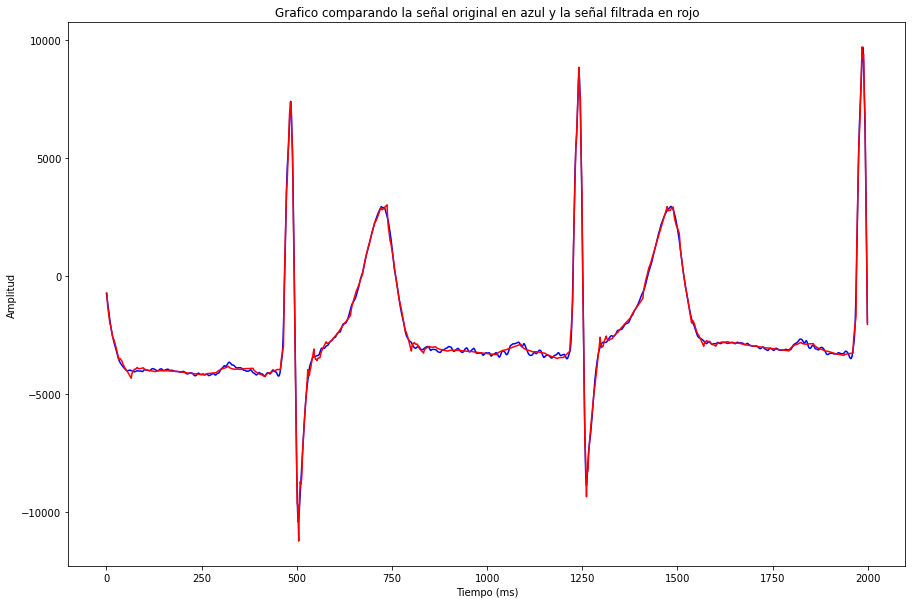

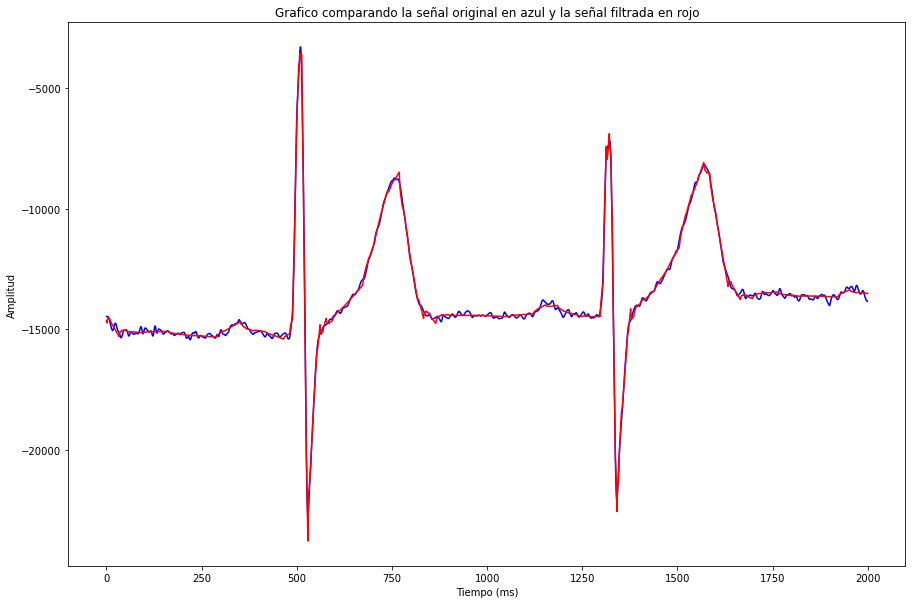

In [7]:
# Mas graficos pero en distintas zonas

plt.figure(figsize=(15, 10))
plt.plot(ecg_one_lead[0:2000],color='blue')
plt.plot(signal[0:2000],color='red')
plt.title('Grafico comparando la señal original en azul y la señal filtrada en rojo')
plt.ylabel('Amplitud')
plt.xlabel('Tiempo (ms)')

plt.figure(figsize=(15, 10))
plt.plot(ecg_one_lead[108000:110000],color='blue')
plt.plot(signal[108000:110000],color='red')
plt.title('Grafico comparando la señal original en azul y la señal filtrada en rojo')
plt.ylabel('Amplitud')
plt.xlabel('Tiempo (ms)')

Text(0.5, 0, 'Tiempo (ms)')

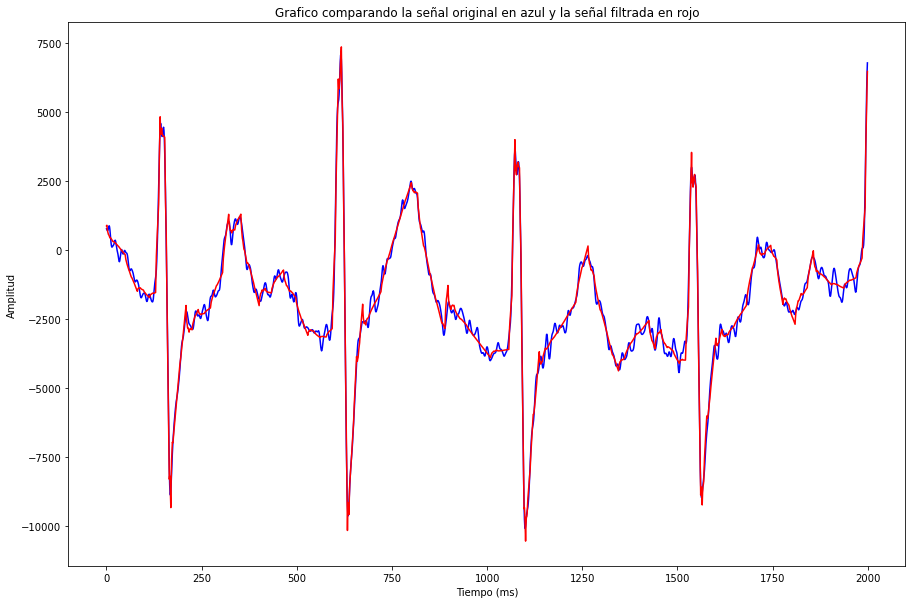

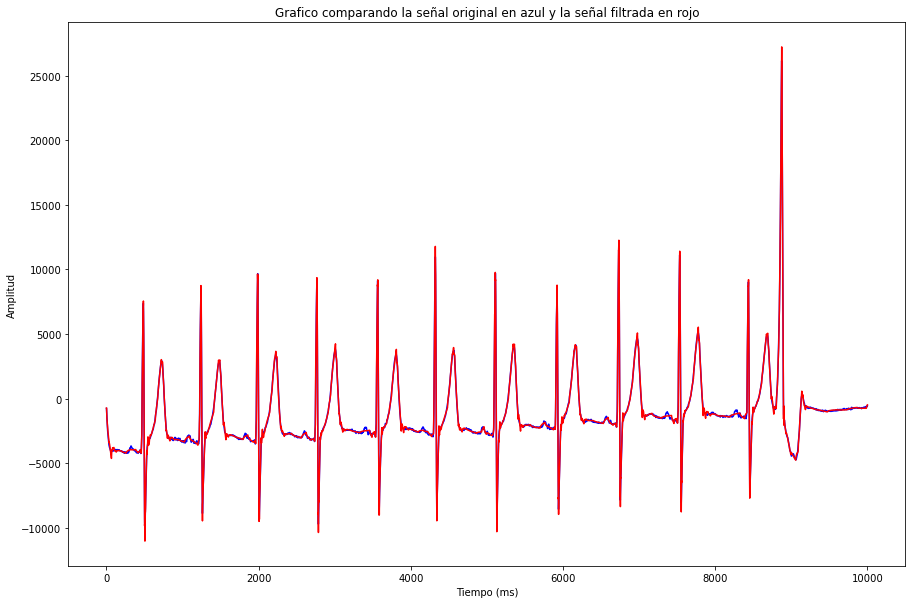

In [10]:
# Filtrado del ruido de alta frecuencia del ecg realizando una descomposicion multiresolucion con la dwt.
# Usando la funcion arctg

N = len(ecg_one_lead)
LastLevel = 10

coeffs = pywt.wavedec(ecg_one_lead.reshape(N), 'db2', level=LastLevel)

alfa = 3
desvio = 1.483 * np.median(abs(np.concatenate(coeffs[1:-1], axis=None)))
th = desvio*np.sqrt(2*np.log(N)) * 3
for j in range(1,len(coeffs)):
#    threshold = th / np.log(LastLevel-j+2)
    threshold = th
    for i in range(len(coeffs[j])):
        absWjk = abs(coeffs[j][i])
        if absWjk < threshold:
            coeffs[j][i] = np.sign(coeffs[j][i]) * (absWjk/np.pi) * (np.arctan(5*(absWjk-threshold))+np.pi/2)
        else:
            coeffs[j][i] = np.sign(coeffs[j][i]) * (absWjk/np.pi) * (np.arctan(2*(absWjk-threshold))+np.pi/2)
# Remocion de linea de base
# coeffs[0][:] = 0

signal = pywt.waverec(coeffs, 'db2')

plt.figure(figsize=(15, 10))
plt.plot(ecg_one_lead[710800:712800],color='blue')
plt.plot(signal[710800:712800],color='red')
plt.title('Grafico comparando la señal original en azul y la señal filtrada en rojo')
plt.ylabel('Amplitud')
plt.xlabel('Tiempo (ms)')

plt.figure(figsize=(15, 10))
plt.plot(ecg_one_lead[0:10000],color='blue')
plt.plot(signal[0:10000],color='red')
plt.title('Grafico comparando la señal original en azul y la señal filtrada en rojo')
plt.ylabel('Amplitud')
plt.xlabel('Tiempo (ms)')